In [2]:
%matplotlib widget
from pathlib import Path
import sys
import os
base_path = Path(os.path.abspath('')).parent
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append(str(base_path))
import torch
from modules.tensor_nerf import TensorNeRF
from fields.listrf import ListRF
from samplers.nerf_acc import NerfAccSampler
from icecream import ic

import imageio
import numpy as np

import matplotlib.pyplot as plt


def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im.copy())
    plt.close()
    display(fig.figure)

Warp 0.6.2 initialized:
   CUDA Toolkit: 11.5, Driver: 12.0
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA GeForce RTX 3090 (sm_86)
   Kernel cache: /home/dronelab/.cache/warp/0.6.2


In [54]:


log_dir = Path("../log") / "noprednorms_nl0_conserve_pb0"
ckpt1 = log_dir / 'car_v38' / 'car_v38.th'
ckpt2 = log_dir / 'toaster_v38' / 'toaster_v38.th'
ckpt1 = '../log/car_v38_freezelayers/car_v38_freezelayers.th'
ckpt2 = '../log/toaster_v38_freezelayers/toaster_v38_freezelayers.th'

ckpt1 = '../log/car_v38_freezelayers_randbg/car_v38_freezelayers_randbg.th'
ckpt2 = '../log/toaster_v38_freezelayers_randbg/toaster_v38_freezelayers_randbg.th'

tensorf1 = TensorNeRF.load(torch.load(ckpt1), near_far=[1, 6], strict=False)
tensorf2 = TensorNeRF.load(torch.load(ckpt2), near_far=[1, 6], strict=False)
device = torch.device('cuda')
tensorf1 = tensorf1.to(device)
tensorf2 = tensorf2.to(device)
offsets = [
    torch.tensor([[1.2, 0.0, 0, 0]], device=device),
    # torch.tensor([[0.0, 0.0, 0.0, 0]], device=device),
]
new_aabbs = [
    torch.tensor([[-0.8, -1.5, -1.4],
                  [ 0.8,  1.5,  1.4]], device=device),
    # torch.tensor([[-0.8, -1.5, -1.5],
    #               [ 0.8,  1.5,  1.5]], device=device),
]
rots = [
    torch.eye(3, device=device),
    # torch.eye(3, device=device),
]

aabb = torch.tensor([[-2.5, -1.5, -1.5],
                     [ 1.5,  1.5,  1.5]], device=device)

print(aabb)
# listrf = ListRF([tensorf1.rf, tensorf2.rf], offsets, new_aabbs, rots)
# aabb = tensorf1.rf
listrf = ListRF([tensorf1.rf], offsets, new_aabbs, rots)
tensorf = tensorf2
tensorf.rf = listrf
tensorf.rf.aabb = aabb

tensorf.sampler = NerfAccSampler(aabb, [1, 6], grid_size=128,
         render_n_samples=1024, max_samples=-1, multiplier=1,
         test_multiplier=1, update_freq=16, shrink_iters=[],
         alpha_thres = 0, ema_decay = 0.95, occ_thre=0.005,
         warmup_iters=256).to(device)

tensorf.sampler.update(tensorf.rf, init=True)
for i in range(2000):
    tensorf.sampler.check_schedule(i, 1, tensorf.rf)

ic| grid_size: [tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0')]
ic| self.N_voxel_list: [347217, 1279813, 3167271, 6346304, 11153628, 17925958, 27000000]


grid size tensor([300, 300, 300])
aabb tensor([-1.5000, -1.5000, -1.5000,  1.5000,  1.5000,  1.5000], device='cuda:0')
sampling step size:  tensor(0.0050)
sampling number:  1036


ic| self.use_predicted_normals: False
    self.align_pred_norms: True
    self.orient_world_normals: True
ic| grid_size: [tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0')]
ic| self.N_voxel_list: [347217, 1279813, 3167271, 6346304, 11153628, 17925958, 27000000]
ic| self.use_predicted_normals: False
    self.align_pred_norms: True
    self.orient_world_normals: True


grid size tensor([300, 300, 300])
aabb tensor([-1.5000, -1.5000, -1.5000,  1.5000,  1.5000,  1.5000], device='cuda:0')
sampling step size:  tensor(0.0050)
sampling number:  1036
tensor([[-2.5000, -1.5000, -1.5000],
        [ 1.5000,  1.5000,  1.5000]], device='cuda:0')


In [55]:


from dataLoader.ray_utils import get_ray_directions, get_rays
from renderer import chunk_renderer, BundleRender
import numpy as np

w = 100
h = 100
camera_angle_x = 0.6194058656692505

fx = 0.5 * w / np.tan(0.5 * camera_angle_x)  # original focal length
fy = fx

directions = get_ray_directions(h, w, [fx,fy])  # (h, w, 3)
directions = directions / torch.norm(directions, dim=-1, keepdim=True)
c2w = torch.eye(4)
blender2opencv = torch.tensor([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]).float()

c2w = torch.tensor([
    [
        -0.9999021291732788,
        0.004192245192825794,
        -0.013345719315111637,
        -0.05379832163453102
    ],
    [
        -0.013988680206239223,
        -0.2996590733528137,
        0.95394366979599,
        3.845470428466797
    ],
    [
        -4.6566125955216364e-10,
        0.9540371894836426,
        0.29968830943107605,
        1.2080823183059692
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv
# c2w = torch.tensor([
#     [
#         0.24868656694889069,
#         -0.6090989112854004,
#         0.7530957460403442,
#         3.0358264446258545
#     ],
#     [
#         0.9685839414596558,
#         0.1563878208398819,
#         -0.1933593899011612,
#         -0.7794567346572876
#     ],
#     [
#         -7.450580152834618e-09,
#         0.7775223851203918,
#         0.6288550496101379,
#         2.5349960327148438
#     ],
#     [
#         0.0,
#         0.0,
#         0.0,
#         1.0
#     ]
# ]) @ blender2opencv

c2w = torch.tensor([
    [
        -0.24868960678577423,
        0.6655282974243164,
        -0.7037226557731628,
        -2.836796998977661
    ],
    [
        -0.9685831665992737,
        -0.17087841033935547,
        0.18068504333496094,
        0.7283647656440735
    ],
    [
        0.0,
        0.7265485525131226,
        0.6871150732040405,
        2.7698497772216797
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv

# c2w = torch.tensor([
#     [
#         0.6845461130142212,
#         -0.24688588082790375,
#         0.6858890652656555,
#         2.7649075984954834
#     ],
#     [
#         0.7289695143699646,
#         0.23184067010879517,
#         -0.644091010093689,
#         -2.596414089202881
#     ],
#     [
#         -1.4901159417490817e-08,
#         0.9409023523330688,
#         0.33867788314819336,
#         1.365254282951355
#     ],
#     [
#         0.0,
#         0.0,
#         0.0,
#         1.0
#     ]
# ]) @ blender2opencv




rays_o, rays_d = get_rays(directions, c2w)  # both (h*w, 3)

rays = torch.cat([rays_o, rays_d], 1).to(device)

In [56]:
torch.cuda.empty_cache()

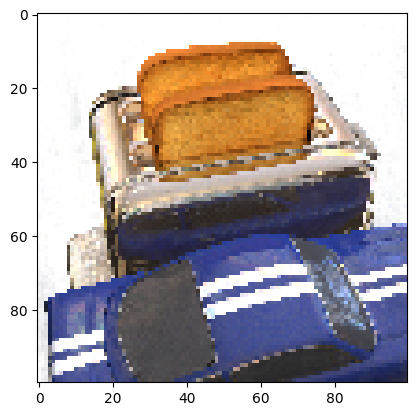

In [57]:
torch.cuda.empty_cache()
tensorf.model.max_retrace_rays=[300000]
tensorf.model.max_brdf_rays=[500000, 500000]
tensorf.eval_batch_size=4000
tensorf.model.russian_roulette = True


brender = BundleRender(chunk_renderer, h, w, 1)
ims, stats = brender(rays, tensorf, N_samples=-1, ndc_ray=False, is_train=False)
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))

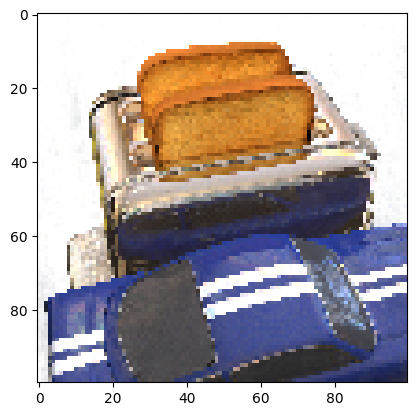

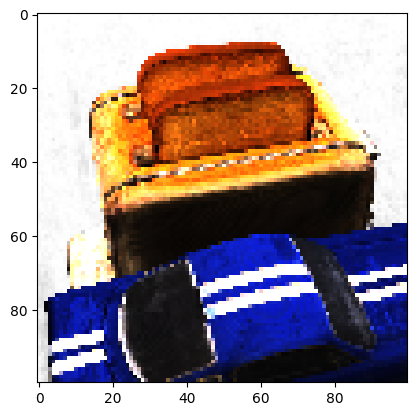

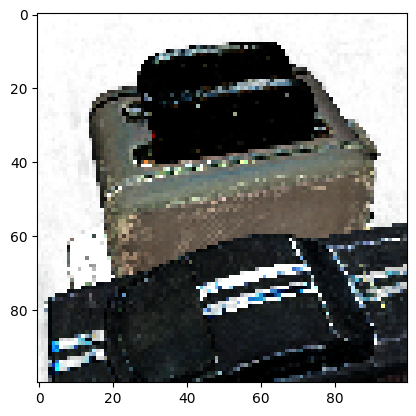

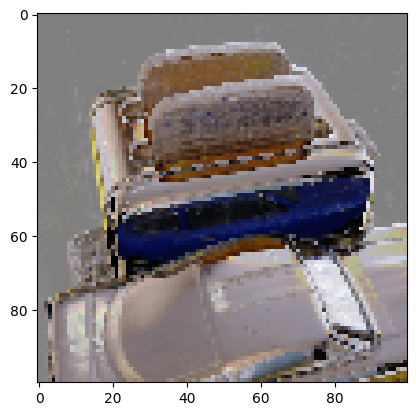

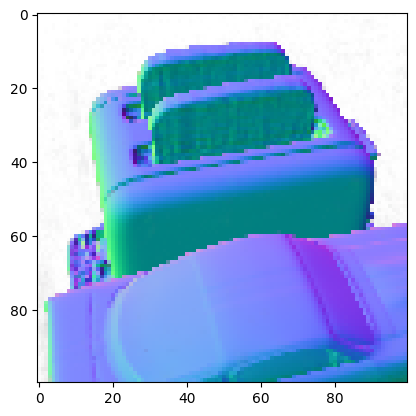

In [58]:
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['diffuse'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['tint'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['spec'] / (ims['spec']+1)*255).numpy().astype(np.uint8))
disp_im((ims['world_normal']*127 + 128).numpy().astype(np.uint8))

In [ ]:

from dataLoader import dataset_dict
datadir = "/optane/nerf_datasets/nerf_synthetic/toastercar"
dataset = dataset_dict['blender']
test_dataset = dataset(datadir, split='test',
                    downsample=1, is_stack=True, white_bg=True, is_testing=True)

Loading data test (200): 100%|██████████| 200/200 [00:09<00:00, 20.75it/s]


In [37]:
torch.cuda.empty_cache()
base = Path('../car_shifted')
i = 0
W, H = test_dataset.img_wh
brender = BundleRender(chunk_renderer, H, W, 1)

(base / 'rgb').mkdir(exist_ok=True, parents=True)
(base / 'acc').mkdir(exist_ok=True, parents=True)
(base / 'depth').mkdir(exist_ok=True, parents=True)
for i in range(len(test_dataset)):
    rays = test_dataset.all_rays[i].to(device)
    ims, stats = brender(rays, tensorf, N_samples=-1, ndc_ray=False, is_train=False)

    im = (ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8)
    acc = (ims['acc_map'].clip(0, 1)*255).numpy().astype(np.uint8)
    imageio.imwrite(base / 'rgb' / f'{i:03d}.png', im)
    imageio.imwrite(base / 'acc' / f'{i:03d}.png', acc)
    imageio.imwrite(base / 'depth' / f'{i:03d}.tiff', ims['depth'].numpy())

In [3]:
path1 = Path("../car_shifted/")
path2 = Path("../log/toaster_v38_freezelayers_randbg/imgs_test_all")
path3 = Path("/optane/nerf_datasets/nerf_synthetic/toaster/test")
(path1 / 'comb').mkdir(exist_ok=True)
for i in range(200):
    rgb1 = imageio.imread(path1 / 'rgb' / f'{i:03d}.png')
    acc1 = imageio.imread(path1 / 'acc' / f'{i:03d}.png').astype(np.float32).reshape(800, 800, 1) / 255
    rgb1 = np.where(acc1 > 0.5, rgb1, 255*np.ones_like(rgb1))
    acc1 = np.where(acc1 > 0.5, acc1, np.zeros_like(acc1))
    dep1 = imageio.imread(path1 / 'depth' / f'{i:03d}.tiff')
    rgb2 = imageio.imread(path2 / f'{i:03d}.png')
    acc2 = imageio.imread(path3 / f'r_{i}.png')[..., 3].astype(np.float32).reshape(800, 800, 1) / 255
    # dep2 = imageio.imread(path3 / f'r_{i}_disp.tiff')
    dep2 = imageio.imread(path2 / 'rgbd' / f'{i:03d}.exr')
    mask = (dep2 > dep1).reshape(*acc1.shape)
    acc1 = np.where(~mask | (dep2.reshape(*acc1.shape) > 0.01), 0, acc1)
    # acc2 = np.where(mask & (dep1.reshape(*acc1.shape) > 0.01), acc2, 0)
    # mask2 = (dep1 < 1e-2) | (dep2 < 1e-2)
    rgb_comb = acc1*rgb1 + acc2*rgb2
    # rgb_comb = np.where((acc1 + acc2) > 1, np.where(mask, rgb1, rgb2), rgb_comb)
    # rgb_comb = np.where((acc1 > 0.15) & ((acc2) > 0.15), np.where(mask, rgb1, rgb2), rgb_comb)
    rgb_comb = rgb_comb.clip(min=0, max=255).astype(np.uint8)
    imageio.imwrite(path1 / 'comb' / f'{i:03d}.png', rgb_comb)

/tmp/ipykernel_2579969/2728961150.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb1 = imageio.imread(path1 / 'rgb' / f'{i:03d}.png')
/tmp/ipykernel_2579969/2728961150.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  acc1 = imageio.imread(path1 / 'acc' / f'{i:03d}.png').astype(np.float32).reshape(800, 800, 1) / 255
/tmp/ipykernel_2579969/2728961150.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `ima

KeyboardInterrupt: 